In [ ]:
from dotenv import load_dotenv
load_dotenv()

#### Cadenas con RunnableSequence y RunnableParallel
Propósito del ejemplo

El principal objetivo de este ejemplo de código es mostrar cómo implementar las clases  <br>
RunnableSequence, RunnableParallel y RunnablePassthrough. Adicionalmente se explora la   <br>
reacción del LLM cuando recibe un contexto muy escueto y cuando se modifica la temperatura.   <br>
Se carga un texto sencillo, por lo cual se omite particion e incrustación.

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import (RunnableParallel, 
RunnablePassthrough, RunnableSequence)
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq

mixtral = ChatGroq(model="mixtral-8x7b-32768", temperature=0)     # 1.5
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.from_texts(
    ["Langchain es gran ayuda para crear chatbots"],
    embedding = embeddings,
)
retriever = vectorstore.as_retriever()

template = """Responda en base al siguiente contexto:

{context}

Consulta: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
output_parser = StrOutputParser()

# Hasta aqui el codigo es conocido. 
# Sigue aplicacion de RunnableParallel con un diccionario
setup_and_retrieval = RunnableParallel({"context": retriever, "question": RunnablePassthrough()})

# Sintaxis alternativa cn tuplas 
#setup_and_retrieval = RunnableParallel(context= retriever, question= RunnablePassthrough())

#chain = setup_and_retrieval | prompt | mixtral | output_parser
chain = RunnableSequence(first=setup_and_retrieval, middle=[prompt, mixtral], last=output_parser)

chain.invoke("Para que sirve LangChain? Responder en español")

#### Chatbot RAG y cadena
**Propósito del ejemplo** <br>
Aunque similar al anterior, este ejemplo explora el efecto de emplear como método de recuperación búsqueda por similitud semántica y máxima relevancia marginal (MMR). Y también muestra la facilidad de utilizar un mismo código para consultas diferentes. Se carga un texto extenso, por lo cual se requiere implementar un sistema RAG.

**Fuente** <br>
Se emplea el artículo https://biblioteca.cejamericas.org/bitstream/handle/2015/1280/Plata-o-Plomo-Bribe-and-Punishment-in-a-Theory-of-Political-Influence.pdf?sequence=1&isAllowed=y, de Rafael Di Tella sobre la influencia de sobornos comparado con penalidades en obtener influencia politica. El documento está en la carpeta directorio. 

In [ ]:
from langchain_groq import ChatGroq
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

loader = PyPDFLoader("directorio/Plata-o-Plomo-Bribe-DiTella.pdf")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
splits = text_splitter.split_documents(docs)
model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}

# Este modelo de embeddings es el mas poderoso hasta la fecha
BGE_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, 
    model_kwargs=model_kwargs, 
    encode_kwargs=encode_kwargs
)
vectorstore = Chroma.from_documents(documents=splits, embedding=BGE_embeddings)

##### Construccion de la cadena

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.prompts import ChatPromptTemplate 

retriever = vectorstore.as_retriever(search_type="mmr",
                                     search_kwargs={"k": 6})     # Cambiar similarity por mmr

rag_prompt_template = """
        Utiliza la informacion en contexto para responder a la pregunta. Si no sabes la pregunta di "no lo se". \n\n       

        {contexto}
      
        \nPregunta: {pregunta}        
        Respuesta en español:
"""

rag_prompt = ChatPromptTemplate.from_template(rag_prompt_template)
retriever = RunnableParallel(
        {
            "contexto": retriever, # bloques extraidos
            "pregunta": RunnablePassthrough() # pregunta del usuario
        }
    )
output_parser = StrOutputParser()
mixtral = ChatGroq(model="mixtral-8x7b-32768",
                   temperature=1,
                   max_tokens=500)
rag_chain = retriever | rag_prompt | mixtral | output_parser

##### A continuacion se hacen consultas

In [ ]:
query = "Cual es el resultado principal de la investigacion? Tu respuesta debe ser tecnica y detallada. Por favor genera caracteres especiales para formatear tu respuesta."
print(rag_chain.invoke(input=query))

In [ ]:
query2 = "Es la plata o el plomo mas efectivo en obtener influencia politica segun la investigacion de Di Tella?"
print(rag_chain.invoke(query2))

##### El schema: codificación
Propósito del ejemplo   <br>
Conocer los schema de runnables en una cadena. Se analiza la cadena rag_chain creada en el ejemplo anterior.

rag_chain = retriever | rag_prompt | mixtral | output_parser

In [ ]:
retriever.input_schema.schema()

In [ ]:
retriever.output_schema.schema()

#### Representación gráfica de una cadena
Propósito del ejemplo <br>
Representar gráficamente la sucesión de eventos en una cadena. Se hace uso de la biblioteca **grandalf**, que implementa el método get_graph.

rag_chain = retriever | rag_prompt | mixtral | output_parser

In [ ]:
#! pip install grandalf
rag_chain.get_graph().print_ascii()

#### Invocar dos modelos
Propósito del ejemplo <br>
El siguiente ejemplo muestra cómo concatenar dos LLM en una cadena. Diferentes LLM ofrecen diferentes prestaciones. Hay casos en que puede ser conveniente llevar a cabo una tarea con un modelo y emplear otro para otra tarea. LangChain y LCEL facilitan implementar esta opción. <br>
El contexto es simular un asesor comercial para una empresa manufacturera. El modelo opera así: El usuario indica el tipo de producto que la empresa habrá de fabricar. En base a esta información el modelo sugiere un nombre para la empresa y seguidamente propone un plan de negocios. Aspectos interesantes del modelo son que el mismo modelo transfiere el nombre al prompt y que se aplican dos LLM.

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq

# Instanciar los modelos
mixtral = ChatGroq(model="mixtral-8x7b-32768",temperature=1)
llama3 = ChatGroq(model="llama3-8b-8192",temperature=1)
# Indicar el tipo de producto a fabricar
USER_INPUT = "jabon perfumado"
# Definir instrucciones
template_producto = "Sugiera un nombre para una fabrica de {product}?"
template_negocio = "Sugiera un modelo de negocio para una empresa de nombre: {company}"
#******************************************
chain = (
  PromptTemplate.from_template(template_producto)
  | mixtral
  | {'company': RunnablePassthrough()}
  | PromptTemplate.from_template(template_negocio)
  | llama3
)

modelo_negocio = chain.invoke(input = USER_INPUT)
print(modelo_negocio)

#### Cadenas con funciones personalizadas
Propósito del ejemplo <br>
Supongamos que tenemos una función en Python y deseamos emplearla en una cadena de LangChain. Para ello hay que convertirla en un runnable, un objeto que LangChain sepa manejar. Esto se logra aplicando la clase RunnableLambda, que convierte funciones arbitrarias en runnables. 

In [ ]:
# Chain con dos operaciones matematicas
from langchain_core.runnables import RunnableLambda

def suma(x):
    return x + 4

def divide(x):
    return x / 2
    
suma = RunnableLambda(suma)
divide = RunnableLambda(divide)
mate = suma  | divide
mate.invoke(5)

In [ ]:
# Chain multiple con texto y numeros
from langchain_core.runnables import RunnableLambda

def suma(x):
    s = x + 4
    return s

def mult(x):
    t = x ** 3
    return t
    
def escribe(t):
    print(f"La cuenta da ", t)
    
runnable_suma = RunnableLambda(suma)
runnable_mult = RunnableLambda(mult)
runnable_escribe = RunnableLambda(escribe)
mixto = runnable_suma  | runnable_mult | runnable_escribe
mixto.invoke(5)

##### Demostracion de Runnable Parallel

In [ ]:
from langchain_core.runnables import RunnableParallel

mate2 =  RunnableParallel({ "suma":suma,"divide":divide})
mate2.invoke(5)

#### Chain-of-Thought con operaciones algebraicas - Ejemplo 1
Propósito del ejemplo <br>
Chain-of-Thought (cadena de razonamiento) es una técnica de prompt que consiste en estimular al modelo a pensar en cómo resolver el problema por partes, consecutivamente hasta llegar a la respuesta final. En ciertos casos es suficiente un instrucción escueta, como se ve en este ejemplo. 

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain_groq import ChatGroq

def ecuacion(x):
    return f"x * 3 + 5 = {x * 3 + 5}"

chain = RunnableLambda(ecuacion) | PromptTemplate.from_template(
    """
    Cual es el valor de x en la ecuacion? Procede paso a paso. \n

    {ecuacion}
     
    """
) | ChatGroq(model="gemma-7b-it")
print(chain.invoke(2).content)

#### Chain-of_Thought con operaciones algebraicas - Ejemplo 2
Propósito del ejemplo <br>
En este caso el problema se formula verbalmente y se da al modelo instrucciones más detalladas sobre cómo proceder, cómo ordenar la reflexión.

In [ ]:
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain_groq import ChatGroq

# Definir un prompt para gestionar Chain-of-Thought
cot_prompt_template = """
Eres un asistente habil en matematicas. Por favor responde la pregunta:

Pregunta: {question}

Proceder paso a paso.
"""
# Initializar un LLM
llm = ChatGroq(model="llama3-8b-8192",temperature=0)

# Create a prompt template
prompt = PromptTemplate(template=cot_prompt_template, input_variables=["question"])

# Definir la logica de Chain-of-Thought como funcion de Python
def chain_of_thought(input_text):
    razonamiento = [
        "Primero, identificar el numero inicial de manzanas.",
        "Seguidamente, anotar cuantas manzanas fueron comidas.",
        "Finalmente, restar las manzanas comidas del total inicial para determinar cuantas quedan."
    ]
    return "\n".join(razonamiento) + "\nLa respuesta final es: " + input_text

# Envolver la funcion con RunnableLambda
logica = RunnableLambda(chain_of_thought)

# Crear una cadena 
cadena = prompt | llm | StrOutputParser() | logica

# Define the question
question = "Si hay 5 manzanas se comen 2, cuantas manzanas quedan?"

# Invocar la cadena con question
respuesta = cadena.invoke(question)
print(respuesta)

In [ ]:
#%pip install -U langchain-ollama

#### Constructores prediseñados - create_stuff_documents_chain y create_retrieval_chain
Propósito del ejemplo <br>
Construir una cadena empleando los constructores create_stuff_documents_chain y create_retrieval_chain. Explorar cómo se complementan. El ejemplo se divide en tres partes, la primera desarrolla el RAG hasta el prompt, y las otras ejemplifican el uso de los constructores.

In [ ]:
# Codigo en comun
from langchain_community.document_loaders import PyPDFLoader
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = PyPDFLoader("./directorio/WorldBank.pdf")
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
documents = text_splitter.split_documents(docs)
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
db = FAISS.from_documents(documents=docs[0:20], embedding=embeddings)
llm = ChatGroq(model="llama3-8b-8192")

# Crear el prompt
prompt = ChatPromptTemplate.from_template(""" Responda basandose en el contexto dado abajo.
<contexto>
{context}
</contexto>
Question: {input}""")

In [17]:
# Crear chain con StuffDocumentChain
from langchain.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(llm, prompt)
print(document_chain.invoke({"context":documents, "input":"What is Young Adulthood?"}))

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hyr7phrjfejbqhr8mzc7r5p1` on tokens per minute (TPM): Limit 30000, Used 0, Requested 394527. Please try again in 12m9.054s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [18]:
# Crear chain con create_retrieval_chain
from langchain.chains import create_retrieval_chain

retriever = db.as_retriever()
retrieval_chain = create_retrieval_chain(retriever, document_chain)
#retrieval_chain.invoke({'input':'Who are the authors?'})
response = retrieval_chain.invoke({"input": "What does the document say about adulthood?"})
response["answer"]

"According to the document, in the context of developing countries, the time has never been better to invest in young people because the number of people worldwide aged 12-24 years has reached 1.3 billion, the largest in history. It is also mentioned that today's youth are tomorrow's workers, entrepreneurs, parents, active citizens, and leaders."

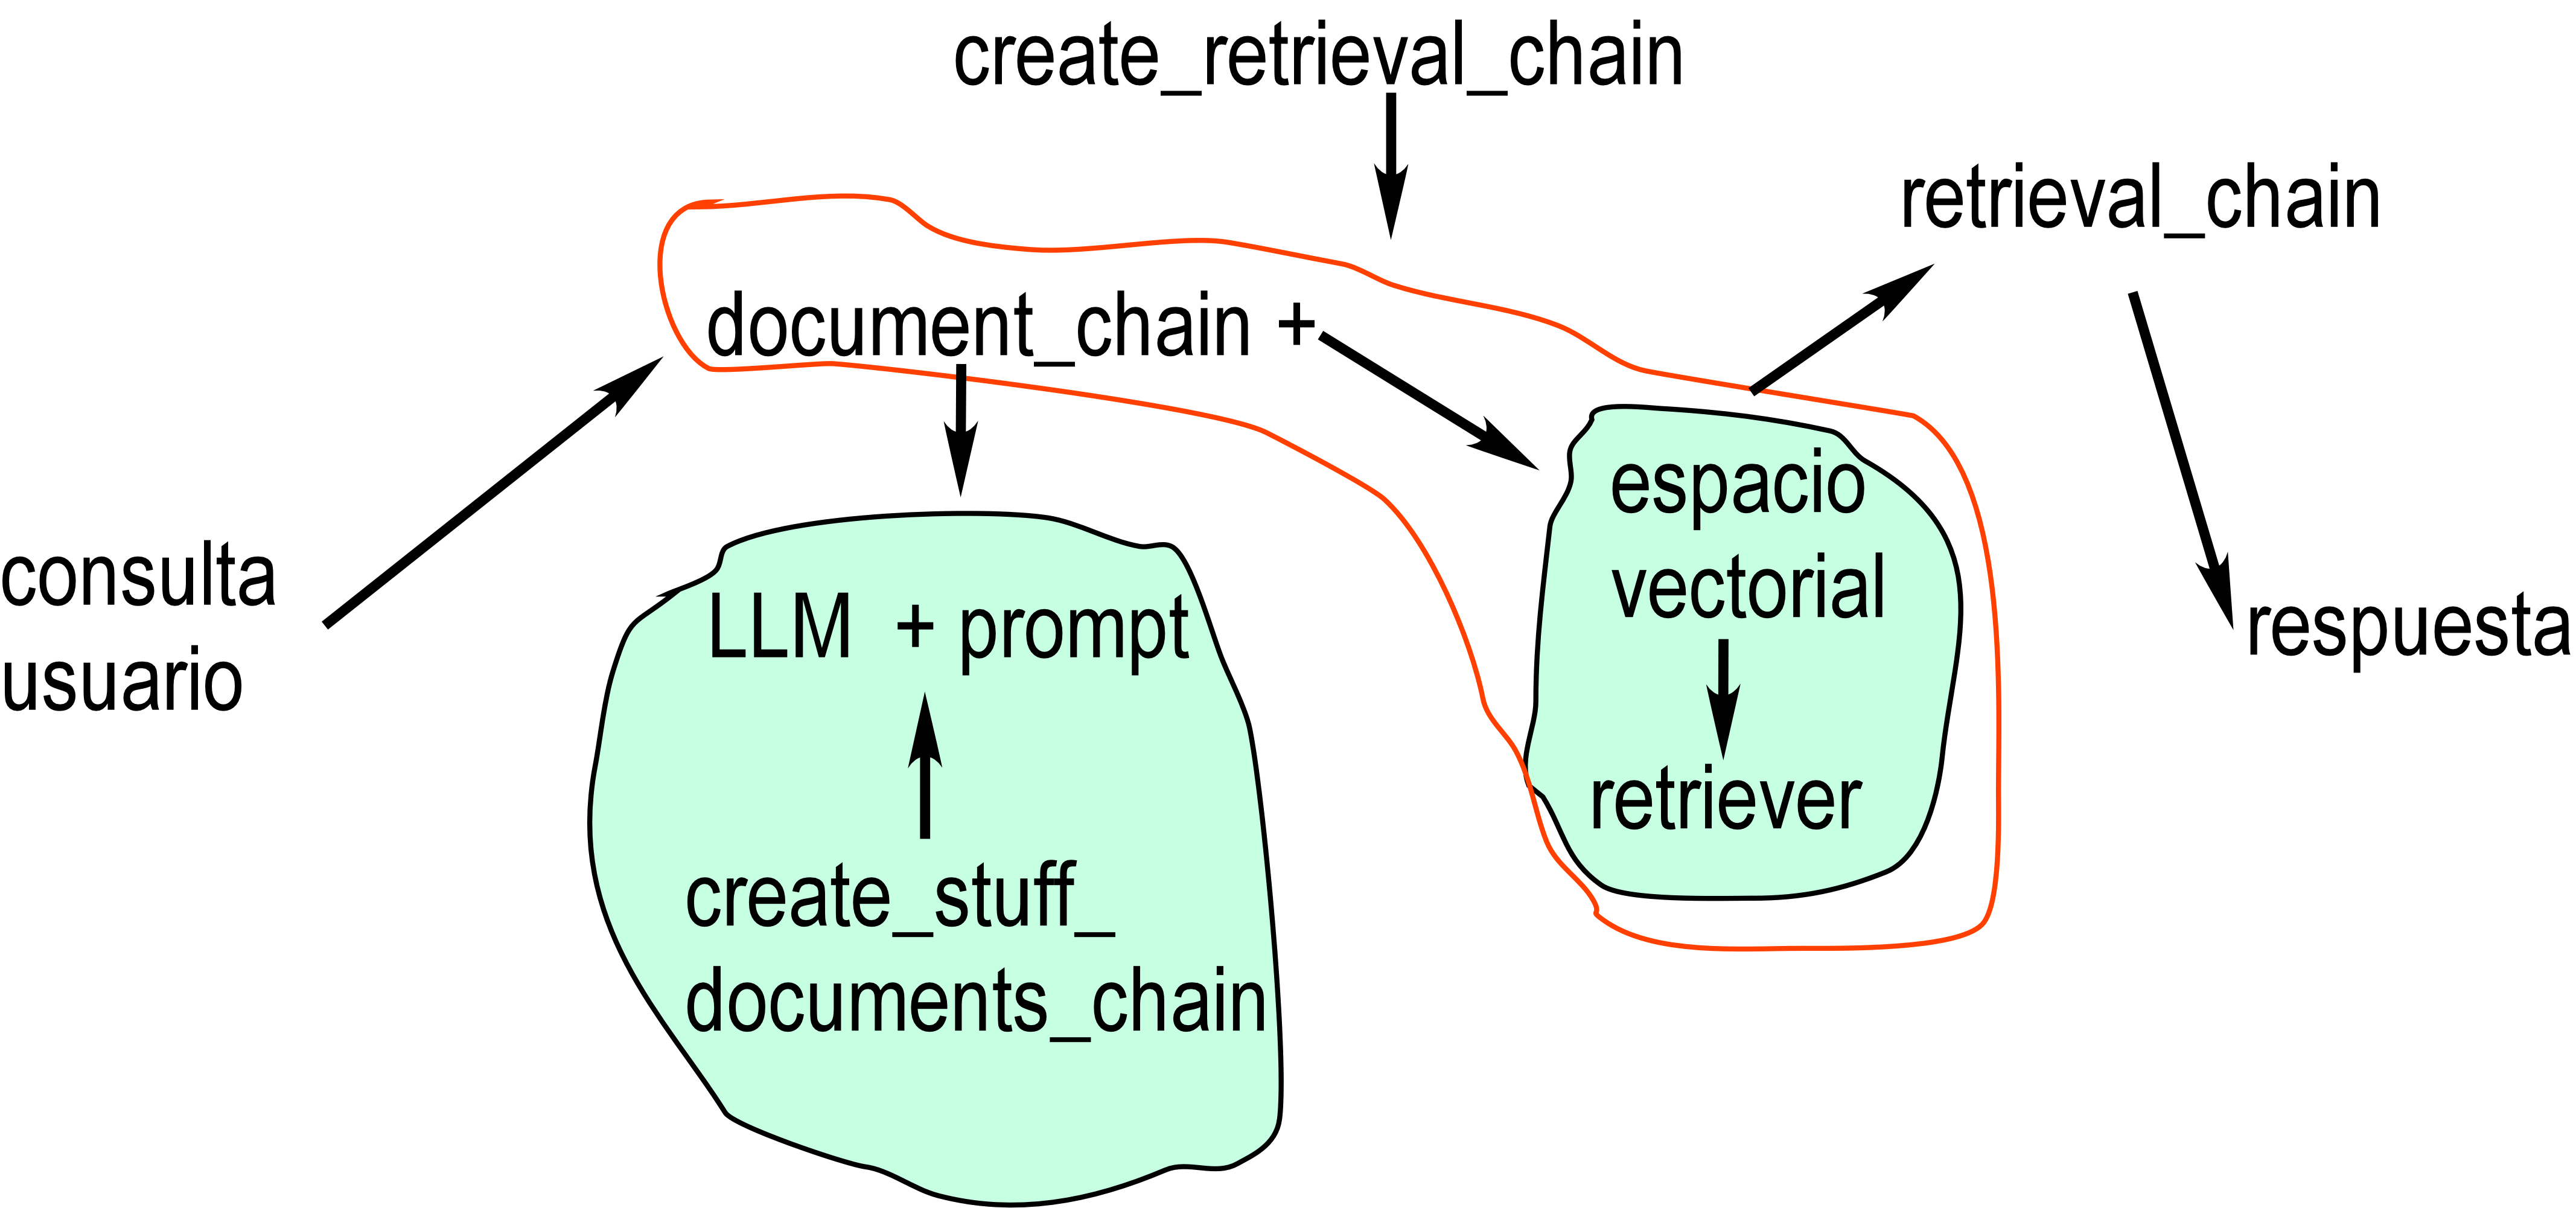

#### Cadenas con memoria
Propósito del ejemplo <br>
Ampliar la capacidad de memoria de nuestro chatbot.



In [ ]:
import bs4
from langchain import hub
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os

# Esta sentencia se puede omitir
os.environ['USER_AGENT'] = 'LangChainRetrieverApp/1.0'

# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

prompt = hub.pull("rlm/rag-prompt")
llm = ChatGroq(model="llama3-8b-8192")

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = FAISS.from_documents(documents=splits, embedding=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2"))

# Crear un retriever y extraer informacion del espacio vectorial
retriever = vectorstore.as_retriever()

#************************************************************************************
# A partir de aqui va codigo nuevo
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Primer prompt y primera cadena
contexto_system_prompt = """Dado un historial de chats y la ultima consulta del usuario, \
la cual puede referirse a informacion en el historial de chats, formular una pregunta  \
que tenga sentido sin recurrir al historial de chats. Pero NO responda la pregunta, \
solamente reformulela si es necesario, y sino pasarla sin cambios."""

contexto_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contexto_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
retriever_con_historial = create_history_aware_retriever(
    llm, retriever, contexto_q_prompt
)

In [ ]:
# Segundo prompt y dos cadenas
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_system_prompt = """Eres un asistente para preguntas y respuestas. \
Emplea fragmentos de contexto recuperado para responder preguntas. \
Si no sabe la respuesta, simplementa diga No se. \
De respuestas concisas.\

{context}"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(retriever_con_historial, question_answer_chain)

In [ ]:
rag_chain.get_graph().print_ascii()

In [ ]:
# Formulacion de consultas

from langchain_core.messages import HumanMessage

chat_history = []

pregunta = "Que es la Geologia?"
ai_msg_1 = rag_chain.invoke({"input": pregunta, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=pregunta), ai_msg_1["answer"]])

segunda_pregunta = "Que estudia?"
ai_msg_2 = rag_chain.invoke({"input": segunda_pregunta, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=segunda_pregunta), ai_msg_2["answer"]])

tercera_pregunta = "Quienes fueron sus precursores?"
ai_msg_3 = rag_chain.invoke({"input": tercera_pregunta, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=tercera_pregunta), ai_msg_3["answer"]])

cuarta_pregunta = "Es una disciplina reciente?"
ai_msg_4 = rag_chain.invoke({"input": cuarta_pregunta, "chat_history": chat_history})


print(ai_msg_4["answer"])

In [ ]:
!set USER_AGENT=LangChainRetrieverApp/1.0

#### Cadenas ramificadas

In [ ]:
# The Python script given below throws error. 
# Please review the script and explain origin of errors and how to correct them.

# Script follows:
from langchain.chains import SimpleSequentialChain, TransformChain
from langchain.prompts import PromptTemplate

def is_question(input_text):
    return input_text.strip().endswith('?')


question_chain = TransformChain(
    input_variables=["input_text"],
    transform=lambda input_text: f"You asked a question: {input_text}",
    output_variables=["response"])


statement_chain = TransformChain(
    input_variables=["input_text"],
    transform=lambda input_text: f"You made a statement: {input_text}",
    output_variables=["response"])

def branching_logic(input_text):
    if is_question(input_text):
        return "question_chain"
    else:
        return "statement_chain"

branching_chain = SimpleSequentialChain(
    chains={
        "question_chain": question_chain,
        "statement_chain": statement_chain},
    select_chain_func=branching_logic,
    input_key="input_key",
    output_key="response"
)

test_inputs = ["How is the weather today?", "I like pizza.", "What time is it?"]

for input_text in test_inputs:
    result = branching_chain.invoke({"input_text":input_text})
    print(f"Input: {input_text}")
    print(f"Output: {result['response']}\n")

# *******************************


In [ ]:
from langchain.chains import SimpleSequentialChain, TransformChain
from langchain.prompts import PromptTemplate

def is_question(input_text):
    return input_text.strip().endswith('?')

# Correcting the TransformChain usage with the required fields
question_chain = TransformChain(
    input_variables=["input_text"],
    output_variables=["response"],
    transform=lambda inputs: {"response": f"You asked a question: {inputs['input_text']}"}
)

statement_chain = TransformChain(
    input_variables=["input_text"],
    output_variables=["response"],
    transform=lambda inputs: {"response": f"You made a statement: {inputs['input_text']}"}
)

def branching_logic(input_text):
    if is_question(input_text):
        return "question_chain"
    else:
        return "statement_chain"

# Correcting the usage of SimpleSequentialChain for branching logic
branching_chain = SimpleSequentialChain(
    chains={
        "question_chain": question_chain,
        "statement_chain": statement_chain},
    select_chain_func=branching_logic,
    input_key="input_text",
    output_key="response"
)

test_inputs = ["How is the weather today?", "I like pizza.", "What time is it?"]

for input_text in test_inputs:
    result = branching_chain.invoke({"input_text": input_text})
    print(f"Input: {input_text}")
    print(f"Output: {result['response']}\n")


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import CommaSeparatedListOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_openai import ChatOpenAI

prompt1 = ChatPromptTemplate.from_template("{question1}")
prompt2 = ChatPromptTemplate.from_template("{question2}")
combine_answers_prompt2 = ChatPromptTemplate.from_template(
"""Given the questions: {question1} and {question2} and the below two answers:
Answer 1:
{answer1}

Answer 2:
{answer2}

Combine the viewpoints of two answers and form a coherent combined answer.
"""
)

model1 = ChatOpenAI(temperature=0.5)
model2 = ChatOpenAI(temperature=1)
model3 = ChatOpenAI(temperature=0)

chain1 = prompt1 | model1 | StrOutputParser()
chain2 = prompt2 | model2 | StrOutputParser()
chain3 = combine_answers_prompt2 | model3 | StrOutputParser()

question1 = "Cuales son las principales ventajas de LangChain? Please keep the answer short and concise, limit to 3 bullet points."
question2 = "Cuales son las principales ventajas de combinar Python con LangChain? Please keep the answer short and concise, limit to 3 bullet points."

In [ ]:
combined_chain = {
    "question1": RunnablePassthrough(),
    "question2": RunnablePassthrough(),
    "answer1": chain1,
    "answer2": chain2,
} | chain3

combined_answer = combined_chain.invoke(question)
combined_answer